752
(497, 131, 67, 84)
(364, 131, 56, 81)
(225, 116, 64, 81)
(96, 103, 53, 103)
BOSS
(87, 62, 73, 79)
(217, 60, 67, 70)
(371, 59, 74, 55)
(514, 46, 67, 63)
COME


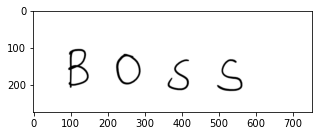

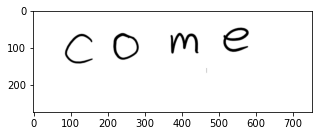

<Figure size 360x360 with 0 Axes>

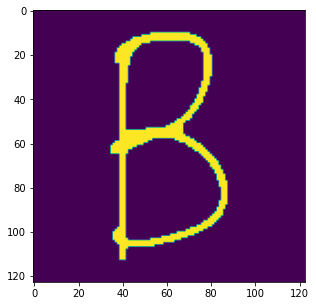

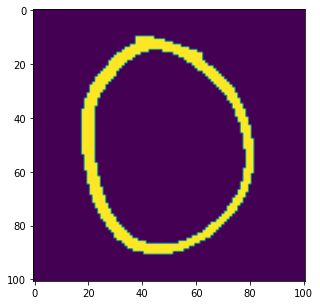

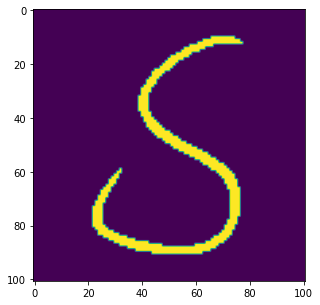

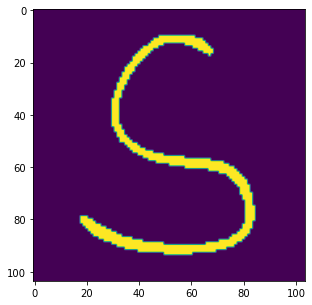

<Figure size 360x360 with 0 Axes>

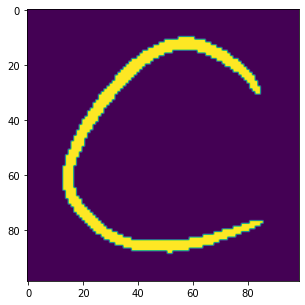

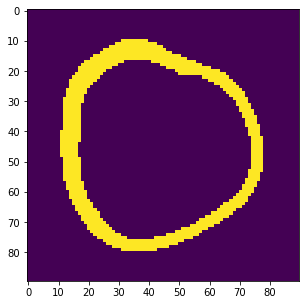

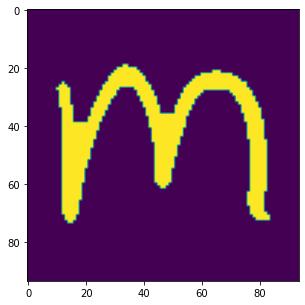

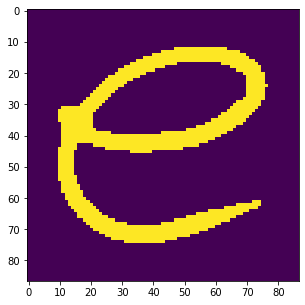

In [24]:
import cv2 
#import imageio
#import scipy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import load_model


def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    for boundingbox in boundingBoxes:
        print(boundingbox)
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)
######################main#############################
img = []
list = []
model = load_model('emnist_trained.h5')#훈련 모델 데려오기
img_color = cv2.imread('./test_data/example.PNG',cv2.IMREAD_COLOR) # 이미지 불러오기 (경로만 바꾸어주면 됨)
print(img_color.shape[1])
plt.figure(figsize=(5,5))
img.append(img_color[0:img_color.shape[0]//2, 0:img_color.shape[1]])
img.append(img_color[img_color.shape[0]//2:img_color.shape[0], 0:img_color.shape[1]])
plt.imshow(img[0])
plt.figure(figsize=(5,5))
plt.imshow(img[1])

for i in range(2):
    s = ''
    img_gray = cv2.cvtColor(img[i], cv2.COLOR_BGR2GRAY) #흑백으로 바꾸어줌

    for i in range(img_gray.shape[0]): #격자없애기(파란색을 기준으로 모든 색은 흰색으로 바꿈)
        for j in range(img_gray.shape[1]):
            if img_gray[i][j] > 30 :
                img_gray[i][j] = 255

#이진화
    ret, img_binary = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
    img_binary = cv2.morphologyEx(img_binary, cv2.MORPH_CLOSE, kernel)
    plt.figure(figsize=(5,5))

#문자 인식
    contours, hierarchy = cv2.findContours(img_binary, cv2.RETR_EXTERNAL,
                                    cv2.CHAIN_APPROX_SIMPLE)

    sorted_ctrs =sort_contours(contours,  method="left-to-right")[0]

    digits = []
#경계선대로 이미지 예측
    for c in sorted_ctrs:
        (x, y, w, h) = cv2.boundingRect(c)
        length = max(w,h)+20
        if(w>h): #정사각형으로 틀을 만들기 위해 새로운 new_x, new_y생성
            mid1 = (w-h)//2
            new_x = x-10
            new_y = y-mid1-10
        else:
            mid2 = (h-w)//2
            new_y = y-10
            new_x = x-mid2-10
        plt.figure(figsize=(5,5))   
        img_digit = np.zeros((length, length, 1), np.uint8)
        img_digit = img_binary[new_y:new_y+length, new_x:new_x+length]#이미지 크롭
        plt.imshow(img_digit)
        kernel = np.ones((5,5), np.uint8)
        img_digit = cv2.morphologyEx(img_digit, cv2.MORPH_DILATE, kernel)
    
    #예측하기 위해 모델 학습한 이미지와 크기 같게 만들기
        img_digit = cv2.resize(img_digit, (28, 28), interpolation = cv2.INTER_AREA)
        img_digit = img_digit /255.0
        img_input = img_digit.flatten().reshape(-1, 28* 28)
        predictions = model.predict(img_input)
    
        number = np.argmax(predictions)
    
    #예측한 부분 표시를 위한 부분
        cv2.rectangle(img_color, (x,y), (x+w, y+h), (255, 255, 0), 2)
    #아래 주석은 정사각형으로 인식된 부분을 보여줌--> 보려면 주석 풀면 됨
    #cv2.rectangle(img_color, (new_x-10, new_y-10), (new_x+length+10, new_y+length+10), (255, 100, 100), 2)
        location = (x+ int(w*0.5), y - 10)
        font = cv2.FONT_HERSHEY_COMPLEX
        fontScale = 1.2
        cv2.putText(img_color, chr(number+64), location, font, fontScale, (0,255,0),2)
        s = s+ chr(number+64)
    print(s)

    #plt.imshow(img_color)
